# Machine Learning: Regression Part 2 (Gradient Descent)

#### Imports

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import numpy as np
import pandas as pd
import os

#### Previous linear regression methods (min SSE) for comparison

In [182]:
# finds beta vector given D and y   
def findCoefficients(x, y):
    x_copy = pd.DataFrame(x.values) # clone x to keep original columns
    x_copy.insert(0, 'Ones', 1)
    x_copy = np.matrix(x_copy.values)
    y = np.matrix(y.values)    
    inner = x_copy.T.dot(x_copy)
    inner_inv = np.linalg.inv(inner)
    betas = inner_inv.dot((x_copy.T.dot(y)))
    return betas

# returns a function that predicts values of 'y' based on given DATAFRAME 'x'
# cat_vars is a list of tuples that represent categorical variables...
# ...with the form ("<column_name>": 0 or 1) 0 if nominal, 1 if ordinal
def getLinearRegFunc(x, y, cat_vars=[], print_betas=True):
    # deal with categorical variables
    for (col, cat) in cat_vars:
        cat_temp = pd.DataFrame(x.loc[:,col])
        # get distinct set of all possible values for categorical
        vector_values = cat_temp.loc[:,col].unique()        
        if (cat == 1): # sort values lexicographically if ordinal
            vector_values.sort()
        for index, value in enumerate(vector_values):
            x.loc[x.loc[:,col] == value, col] = index # replace old categorical var with new vector
            
    # perform linear regression normally from X' to Y
    betas = findCoefficients(x, y)
    
    if print_betas:
        print (pd.DataFrame(betas, columns=['Beta Value'])) # display betas for clarity
    
    def predict(xs):
        x_copy = pd.DataFrame(xs.values)
        x_copy.insert(0, 'Ones', 1)
        x_copy = np.matrix(x_copy.values)
        if (betas.shape[0] - x_copy.shape[1]) == 0:
            return np.matrix(x_copy).dot(betas)
        else:
            raise ValueError('data points must have exactly %d independent variables' % (betas.shape[0] - 1))
    return predict

# does linear regression minimizing sse and returns sse
def computeError(x, y, cat_vars=[], print_betas=1):
    reg_func = getLinearRegFunc(x, y, cat_vars, print_betas)
    inner = np.power(y - (reg_func(x)), 2)
    return reg_func, np.sum(inner) / len(x)

#### Gradient Descent Methods

In [221]:
def computeErrorGD(X, y, betas):
    inner = np.power(((X * betas.T) - y), 2)
    return np.sum(inner) / len(X)

def gradientDescentRegression(X, y, eta, iters, epsilon, cat_vars = []):
    # deal with categorical variables
    for (col, cat) in cat_vars:
        cat_temp = pd.DataFrame(x.loc[:,col])
        # get distinct set of all possible values for categorical
        vector_values = cat_temp.loc[:,col].unique()        
        if (cat == 1): # sort values lexicographically if ordinal
            vector_values.sort()
        for index, value in enumerate(vector_values):
            x.loc[x.loc[:,col] == value, col] = index # replace old categorical var with new vector
            
    x_copy = pd.DataFrame(X.values)
    x_copy.insert(0,'Ones', 1)
    X = np.matrix(x_copy.values)
    y = np.matrix(y.values)
    betas = np.matrix(np.zeros(X.shape[1]))
    temp = np.matrix(np.zeros(betas.shape))
    parameters = int(betas.ravel().shape[1])
    cost = np.zeros(iters)
    iternum = 0
    for i in range(iters):
        error = (X * betas.T) - y

        for j in range(parameters): # move betas by a little bit in a certain direction
            term = np.multiply(error, X[:,j])
            temp[0,j] = betas[0,j] - ((eta / len(X)) * np.sum(term))

        betas = temp
        cost[i] = computeErrorGD(X, y, betas)
        if ((cost[i]  <= (cost[i-1] + epsilon)) and (cost[i]  >= (cost[i-1] - epsilon))):
            print("Stopped at iteration %d" % (i))
            iternum = i
            break;

    print (pd.DataFrame(betas.T, columns=['Beta Value']))
    print ("Gradient Descent Error = ", cost[iternum])
    
    def predict(xs):
        x_copy = pd.DataFrame(xs.values)
        x_copy.insert(0, 'Ones', 1)
        x_copy = np.matrix(x_copy.values)
        if (betas.T.shape[0] - x_copy.shape[1]) == 0:
            return np.matrix(x_copy).dot(betas.T)
        else:
            raise ValueError('data points must have exactly %d independent variables' % (betas.shape[0] - 1))
    return predict

## Part 1-2 Univariate Gradient Descent : Brain weight vs Body weight

In [194]:
brain_data = pd.read_csv('/home/tstan/data/brain.dat', 
                 sep='\s+', 
                 names=['index', 'brain_wt', 'body_wt'])
brain_data = brain_data.drop(['index'], axis = 1) # remove useless index column

# separate x and y to individual dfs
y = brain_data[['brain_wt']] # y
x = brain_data[['body_wt']] # X

In [195]:
predict_brain_wt_GD = gradientDescentRegression(x, y, 0.00002, 300000, 0.000002)
predict_brain_wt, cost = computeError(x, y, [], True)
print("Min SSE Error = ", cost)

Stopped at iteration 233943
   Beta Value
0   10.687897
1    0.341094
Gradient Descent Error =  8095.03182096
   Beta Value
0   10.975060
1    0.340567
Min SSE Error =  brain_wt    8094.96761
dtype: float64


<IPython.core.display.Javascript object>


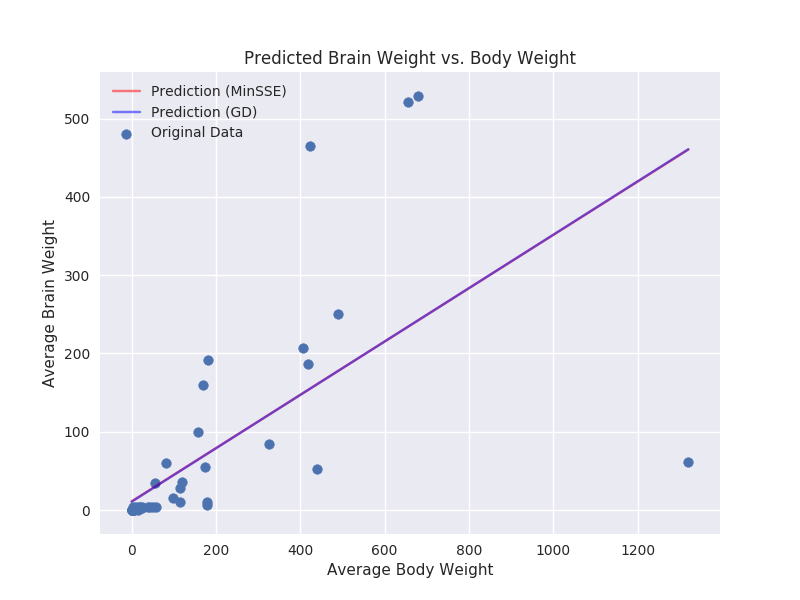

In [200]:
body_wt = brain_data.iloc[:,1]
brain_wt = brain_data.iloc[:,0]
xs = pd.DataFrame(np.linspace(x.min(), x.max(), 100))
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(xs, predict_brain_wt(xs), 'r',alpha=0.5, label='Prediction (MinSSE)')
ax.plot(xs, predict_brain_wt_GD(xs), 'b', alpha=0.5, label='Prediction (GD)')
ax.scatter(body_wt, brain_wt, label='Original Data')
ax.legend(loc = 2)
ax.set_xlabel('Average Body Weight')
ax.set_ylabel('Average Brain Weight')
ax.set_title('Predicted Brain Weight vs. Body Weight')

## Part 2-2 Bivariate Case: Pace of Life

In [202]:
pace_full = pd.read_csv("/home/tstan/data/paceoflife.csv")
pace_data = pace_full[["Walk", "Talk", "Heart"]]
x = pace_data[["Walk", "Talk"]]
y = pace_data[["Heart"]]
pace_data.head()

predict_heart, cost = computeError(x, y, [], True)
print("Min SSE Error = ", cost)

   Beta Value
0   11.021608
1    0.429283
2   -0.019752
Min SSE Error =  Heart    23.233226
dtype: float64


In [207]:
predict_heart_GD = gradientDescentRegression(x, y, 0.000003, 300000, 0.000001)

Stopped at iteration 70125
   Beta Value
0    0.078791
1    0.658104
2    0.258263
Gradient Descent Error =  26.2406010435


<IPython.core.display.Javascript object>


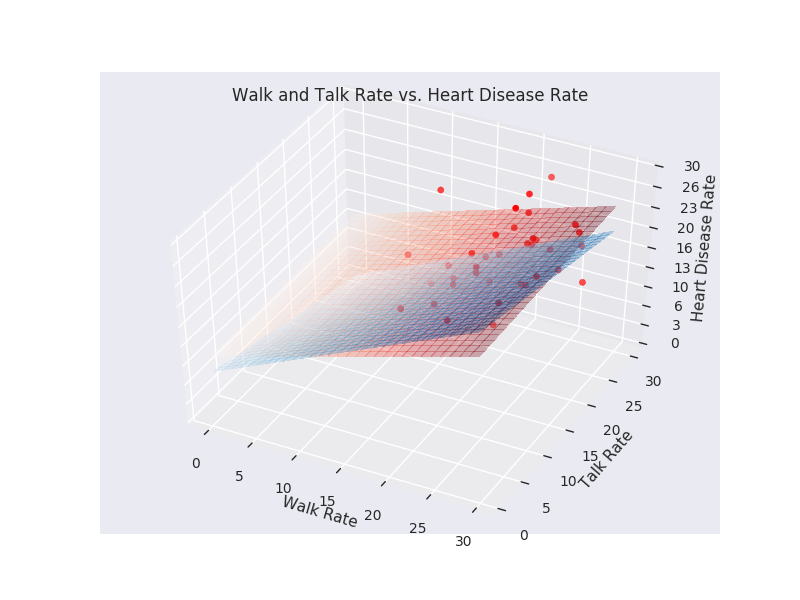

In [216]:
# build all positive integer combinations of talk and walk
pace_space = []
walk = 1
for walk in range(31):
    talk = 1
    for talk in range(31):
        pace_space.append([walk, talk])
pace_space = pd.DataFrame(pace_space, columns=["Walk", "Talk"])

# build z...???
predicted_heart = pd.DataFrame(predict_heart(pace_space))
myZ = np.ndarray(shape=(30,30))
counter = 0
idx = -1
inner = []
for i in predicted_heart.values:
    if counter == 30:
        myZ[idx] = inner
        counter = 0
        inner = []
        idx += 1
    else:
        counter += 1
        inner.append(i)

#build z2
predicted_heart2 = pd.DataFrame(predict_heart_GD(pace_space))
myZ2 = np.ndarray(shape=(30,30))
counter = 0
idx = -1
inner = []
for i in predicted_heart2.values:
    if counter == 30:
        myZ2[idx] = inner
        counter = 0
        inner = []
        idx += 1
    else:
        counter += 1
        inner.append(i)

fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')

X = np.arange(30, 0, -1)
Y = np.arange(0, 30, 1)
X, Y = np.meshgrid(X, Y)

ax.scatter(pace_data.Walk, pace_data.Talk, pace_data.Heart, color='Red')

surf = ax.plot_surface(Y, X, myZ, rstride=1, cstride=1, cmap=cm.Reds, linewidth=0, antialiased=False, alpha = 0.3)
surf = ax.plot_surface(Y, X, myZ2, rstride=1, cstride=1, cmap=cm.Blues, linewidth=0, antialiased=False, alpha = 0.3)

ax.set_zlim(0, 30)
ax.set_xlabel('Walk Rate')
ax.set_ylabel('Talk Rate')
ax.set_zlabel('Heart Disease Rate')
ax.set_title('Walk and Talk Rate vs. Heart Disease Rate')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%d'))

plt.show()

## Part 3-2 Multivariate Case : Red Wine Quality

In [217]:
wine_data = pd.read_csv('/home/tstan/data/winequality/winequality-red.csv',  sep=';')
y = wine_data[['quality']]
x = wine_data
x = x.drop('quality', axis=1)
wine_data.head()

predict_wine, cost = computeError(x, y, [], True)
print("Min SSE Error = ", cost)

    Beta Value
0    21.965208
1     0.024991
2    -1.083590
3    -0.182564
4     0.016331
5    -1.874225
6     0.004361
7    -0.003265
8   -17.881164
9    -0.413653
10    0.916334
11    0.276198
Min SSE Error =  quality    0.416767
dtype: float64


In [220]:
predict_wine_gd = gradientDescentRegression(x, y, 0.000001, 300000, 0.000001)

Stopped at iteration 70203
    Beta Value
0     0.027409
1     0.215697
2     0.011983
3     0.006989
4     0.048514
5     0.002100
6     0.021653
7    -0.004258
8     0.027288
9     0.091680
10    0.019131
11    0.301884
Gradient Descent Error =  0.570094862624


## Part 4-2 Multivariate Categorical : Housing Metrics

In [223]:
house_data = pd.read_csv('/home/tstan/data/housing.data',  sep='\s+', names=['CRIM', 'ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
x = house_data[["RM", "CRIM", "INDUS", "B"]]
x = x.round({"RM":0})  # trim for simple categorical case "RM"
y = house_data[["MEDV"]]
predict_price, cost = computeError(x,y,[("RM", 1)], True)
print("Min SSE Error = ", cost)

   Beta Value
0    2.837300
1    7.232351
2   -0.167075
3   -0.172885
4    0.016346
Min SSE Error =  MEDV    36.682458
dtype: float64


In [224]:
predict_price_GD = gradientDescentRegression(x, y, 0.00001, 300000, 0.00001, [("RM", 1)])

Stopped at iteration 276093
   Beta Value
0    1.038238
1    6.550672
2   -0.150240
3   -0.141581
4    0.024197
Gradient Descent Error =  37.3984951647


### Conclusion

Gradient descent can get pretty close in the case of linear regression but solving cost function analytically seems to be more accurate at least with the learning rate and epsilons chosen (and I've tried a bunch but these are the closest to the analytic results).

Problem being for analytical linear regression, the complexity of calculating the inverse of a nxn matrix which is O(n^3) and as n increases it can take a very long time to finish. When n is low, analytical linear reg is better (more accurate). However for greater values, Gradient Descent is will be much faster.